Test cases: https://ui.adsabs.harvard.edu/abs/2020arXiv201212997C/abstract

In [1]:
import os
import sys

_path = os.path.abspath('../')
if _path not in sys.path:
    sys.path.append(_path)

from pathlib import Path
import requests

from astropy.constants import c as speed_of_light
import astropy.coordinates as coord
from astropy.io import fits
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline

from astropy.nddata import StdDevUncertainty
from specutils.spectra import Spectrum1D

from hq.samples_analysis import extract_MAP_sample

os.environ['APOGEE_CACHE_PATH'] = '/mnt/ceph/users/apricewhelan/apogee'
from subframe.data import Visit
from subframe.config import sdss_auth, plot_path, allstar_path, allvisit_path
from subframe.log import logger
from subframe.velocity import (normalize_ref_to_frame, cross_correlate, 
                               estimate_kernel, bag_of_hacks_cross_correlate,
                               shift_and_interpolate)
from subframe.utils import parabola_optimum
from subframe.plot import plot_spectrum_masked, plot_visit_frames, plot_normalized_ref_spectrum
from subframe.data_helpers import apply_masks

# logger.setLevel(1)

In [2]:
allstar = at.Table.read(allstar_path, hdu=1)
allvisit = at.Table.read(allvisit_path, hdu=1)

In [3]:
# apid = '2M19241171+3650235' # KOI-984
# apid = '2M11291785+4853250' # variable control star
# apid = tmp_id  # see above
# apid = '2M07273995+2420118'  # HAT-P-20
# apid = '2M14272096+0906415'  # null

# short-period Joker
apid = '2M03322788-0658199'
P = 0.7087199091911316

star = allstar[allstar['APOGEE_ID'] == apid]
visits_tbl = allvisit[allvisit['APOGEE_ID'] == apid]
len(visits_tbl)

12

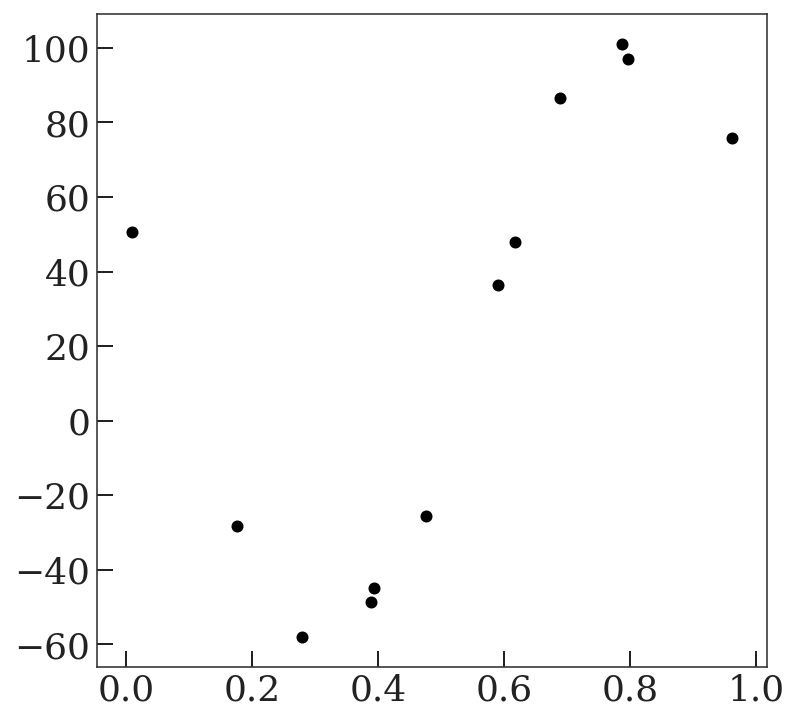

In [4]:
# plt.scatter((visits['JD'] / 0.9631649255752563) % 1., visits['VHELIO'])
# plt.scatter((row['JD'] / 0.9631649255752563) % 1., row['VHELIO'], color='tab:red')
plt.scatter((visits_tbl['JD'] / P) % 1, visits_tbl['VHELIO'])

In [5]:
visits = []
for row in visits_tbl:
    visit = Visit(row)
    frames = visit.frame_hdulists
    if frames is not None:
        visits.append(visit)
len(visits)

10

In [6]:
combined_spectrum = visit.get_apStar_spectrum(percentile_clip=False)

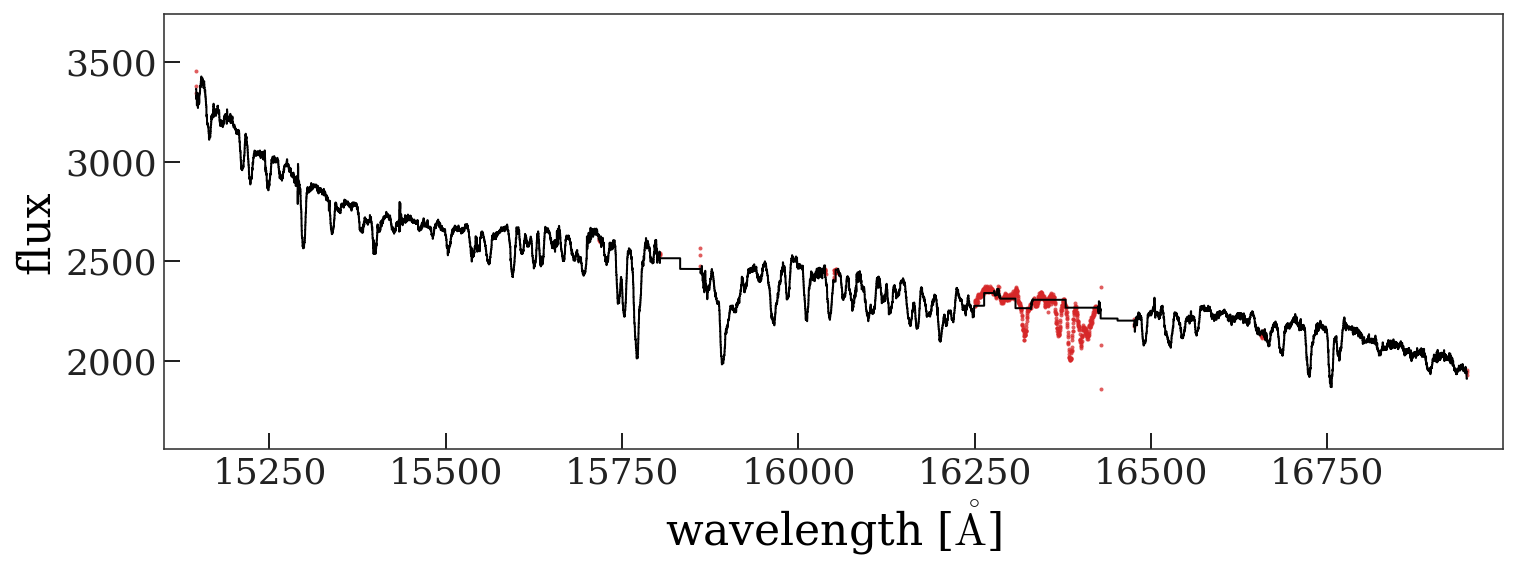

In [7]:
fig = plot_spectrum_masked(combined_spectrum)

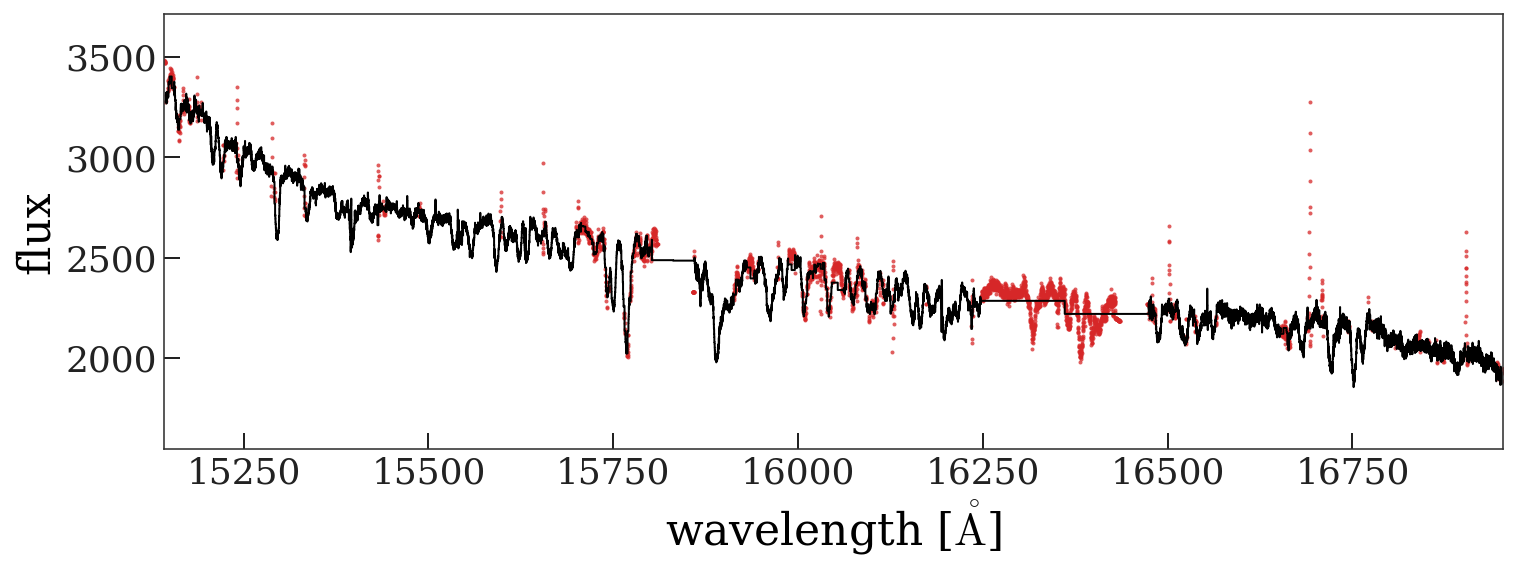

In [8]:
for visit in visits:
    fig = plot_spectrum_masked(visit.get_spectrum())
    break

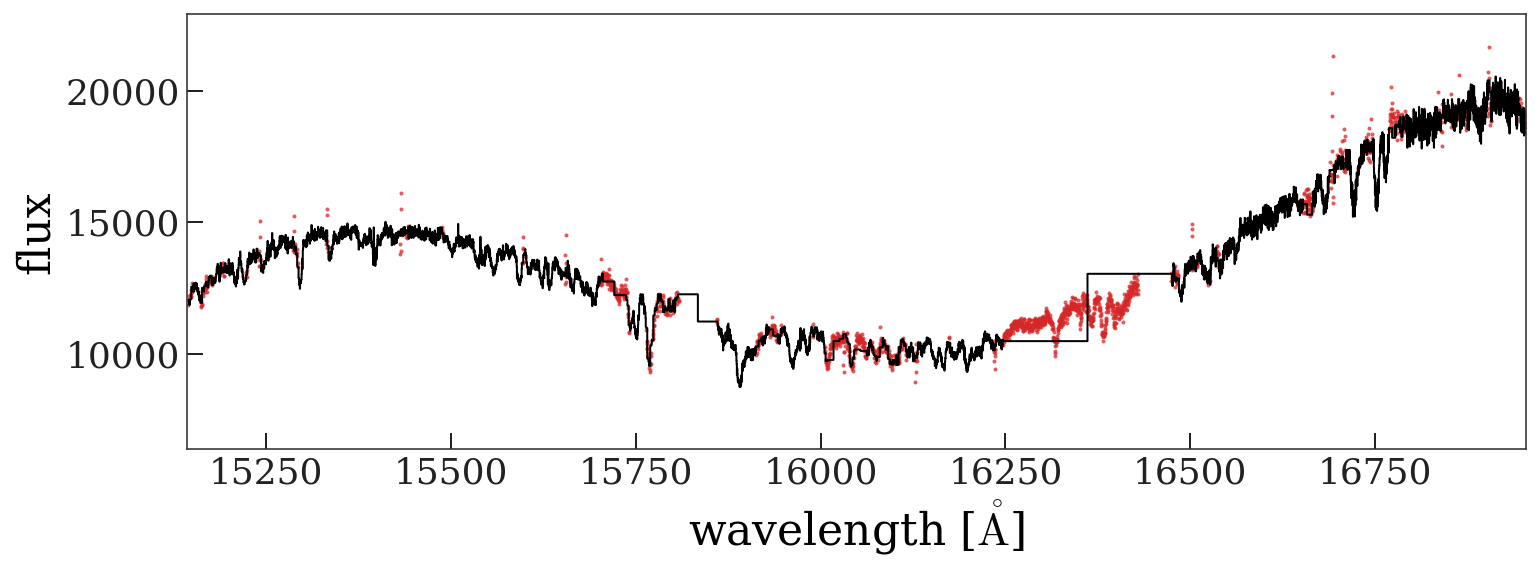

In [9]:
for visit in visits:
    # frame_spectra = visit.get_frame_spectra(percentile_clip=False)
    frame_spectra = visit.get_frame_spectra()
    for k, s in frame_spectra.items():
        fig = plot_spectrum_masked(s)
        break
    break

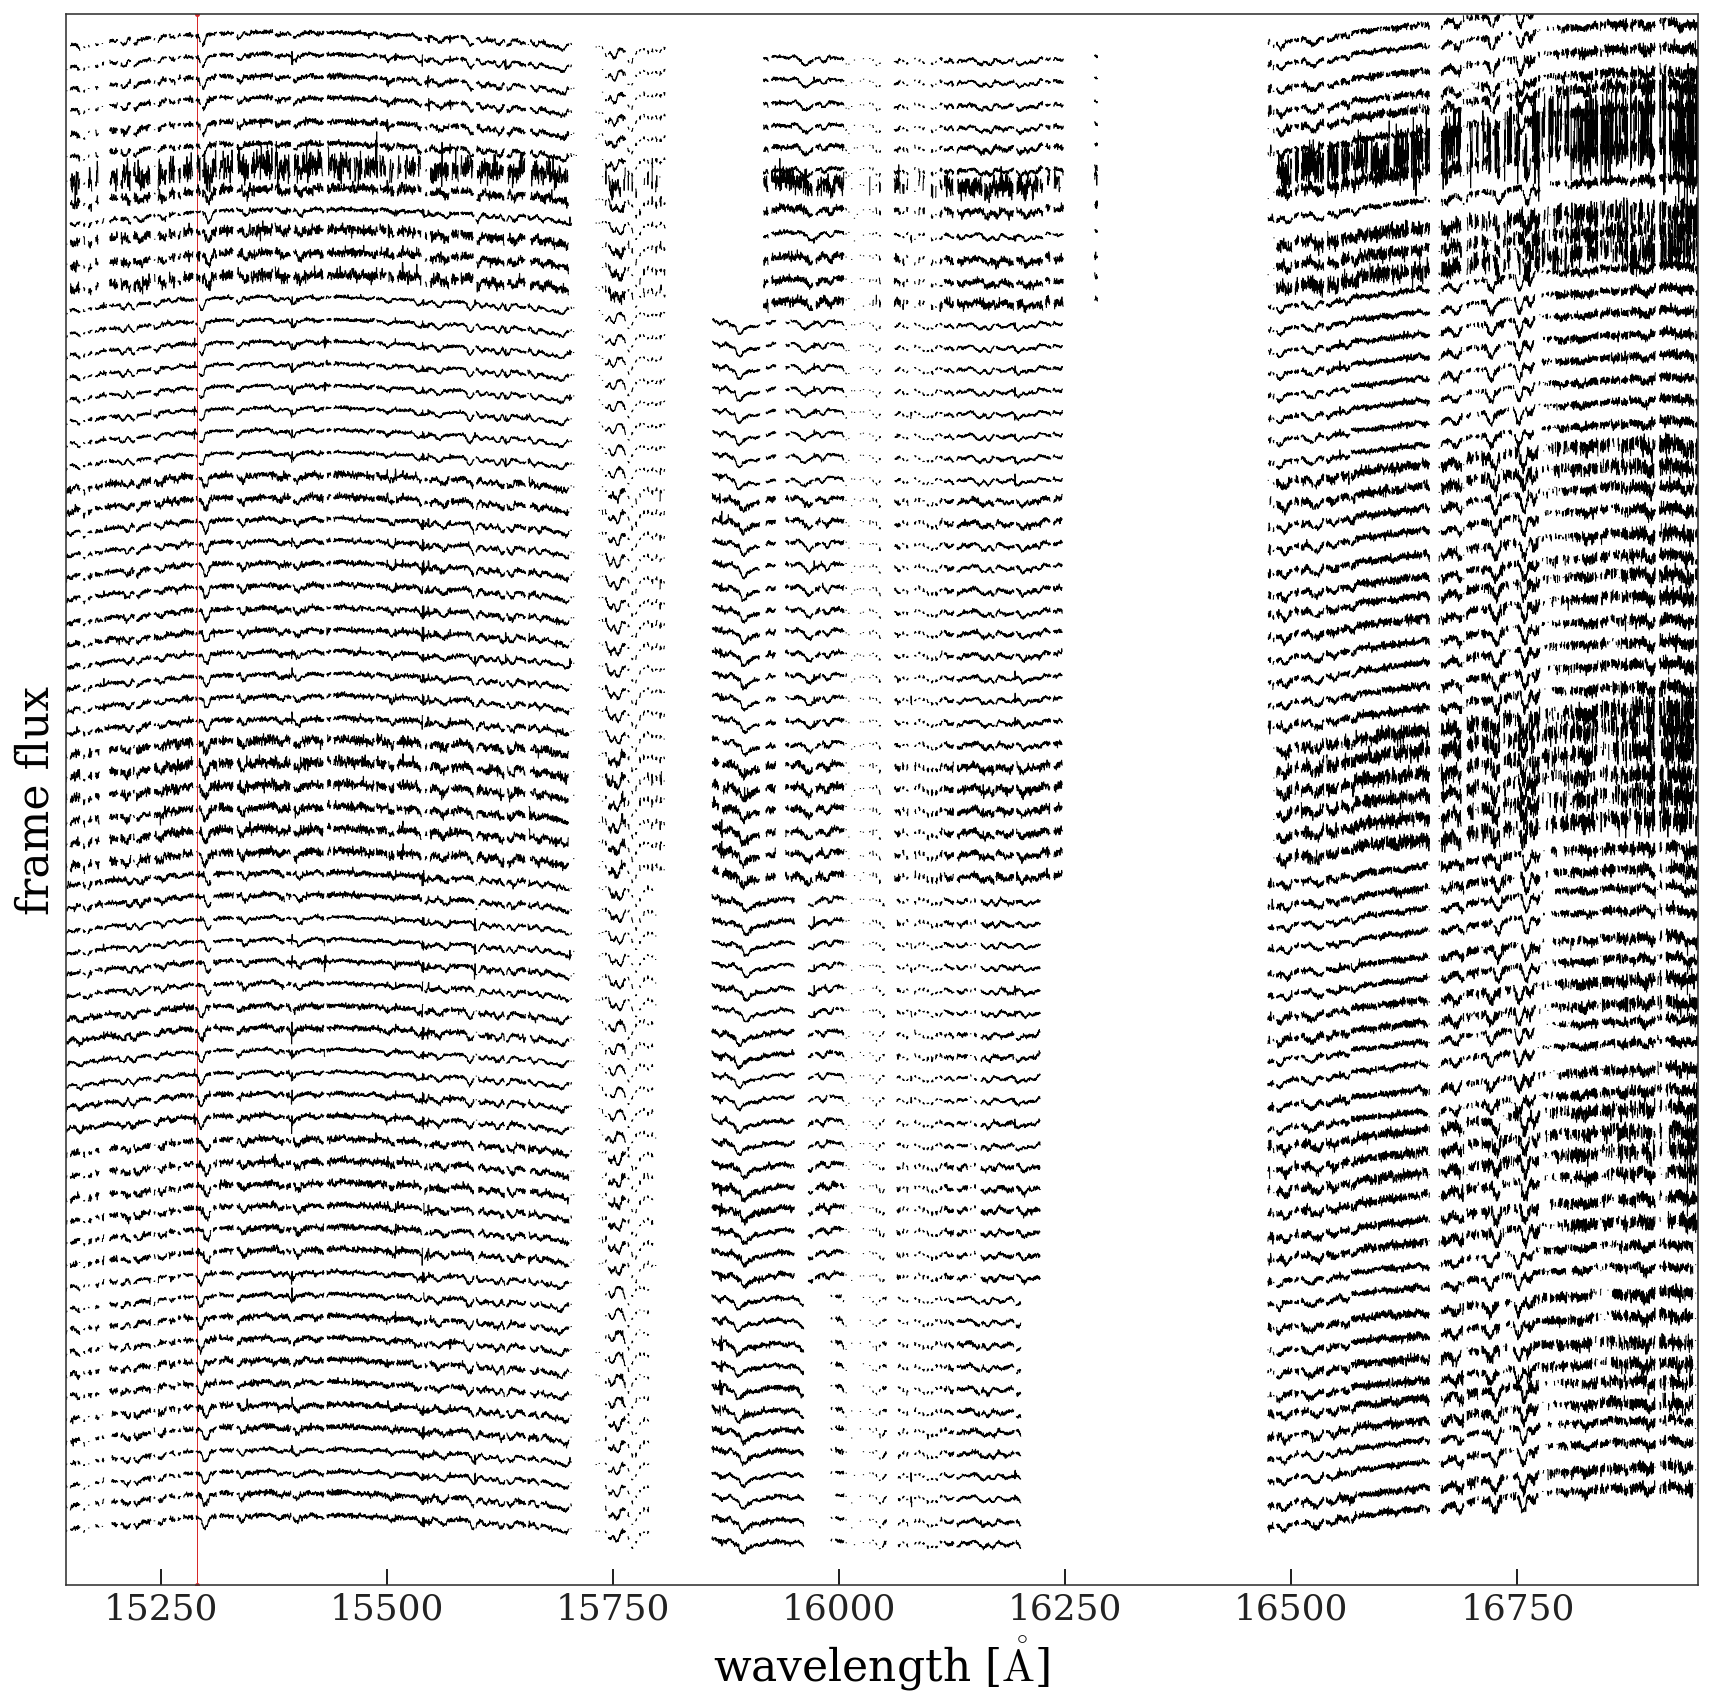

In [12]:
all_frame_spectra = {}
for visit in visits:
    frame_spectra = visit.get_frame_spectra(percentile_clip=True)
    all_frame_spectra.update(frame_spectra)
    
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

for i, k in enumerate(sorted(list(all_frame_spectra.keys()))):
    s = apply_masks(all_frame_spectra[k], fillnan=True)
    
    ax.plot(s.wavelength, 
            s.flux / np.nanmedian(s.flux) + i/4, 
            marker='', lw=0.5, 
            drawstyle='steps-mid', color='k')
ax.axvline(15290, alpha=1, zorder=-10, lw=0.5, color='tab:red')
ax.set_xlim(15145, 16950)
ax.set_ylim(0.25, 18)

ax.set_xlabel(f'wavelength [{u.angstrom:latex_inline}]')
ax.set_yticks([])
ax.set_ylabel('frame flux')

fig.set_facecolor('w')
fig.tight_layout()

In [10]:
# for visit in visits:
#     fig, filename = plot_visit_frames(visit)
#     fig.set_facecolor('w')

#     filename.parent.mkdir(exist_ok=True, parents=True)
#     fig.savefig(filename, dpi=250)

In [11]:
# from astropy.convolution import Gaussian1DKernel, convolve, interpolate_replace_nans
# from scipy.ndimage import gaussian_filter1d
# smooth = 100

# # smooth_frame_flux = gaussian_filter1d(s.flux, sigma=smooth)
# kernel = Gaussian1DKernel(smooth)
# tmp = interpolate_replace_nans(s.flux, kernel, boundary='extend')
# smooth_frame_flux = convolve(tmp, kernel, boundary='extend')
# frame_flux_diff = s.flux - smooth_frame_flux
# frame_flux_diff /= np.linalg.norm(frame_flux_diff)

# plt.plot(s.flux)
# plt.plot(smooth_frame_flux)

In [100]:
from subframe.utils import AA
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.ndimage import gaussian_filter1d


def doppler_factor(dv):
    return np.sqrt((speed_of_light + dv) / (speed_of_light - dv))


def shift_and_interpolate(ref_spectrum, dv, target_wavelength):
    """
    positive dv = shifting reference spectrum to red

    Parameters
    ----------

    """
    shifted_wvln = doppler_factor(dv) * ref_spectrum.wavelength.to_value(AA)
    idx = shifted_wvln.argsort()
    wvln = shifted_wvln[idx]
    flux = ref_spectrum.flux.value[idx]
    
    flux_interp = InterpolatedUnivariateSpline(
        wvln,
        flux,
        k=3, ext=3)
    return flux_interp(target_wavelength.to_value(AA))


def get_wavelength_jumps(wavelength, jump_threshold=0.5*u.angstrom):
    thresh = jump_threshold.to_value(u.angstrom)
    wvln_jumps = np.where(np.diff(wavelength.value) > thresh)[0] + 1
    wvln_jumps = np.concatenate(([0], 
                                 wvln_jumps, 
                                 [len(wavelength)-1]))
    return wvln_jumps


def shift_and_interpolate_splits(ref_spectrum, dv, target_wavelength, 
                                 jump_threshold=0.5*u.angstrom):
    """
    positive dv = shifting reference spectrum to red

    """
    
    wvln_jumps = get_wavelength_jumps(ref_spectrum.wavelength,
                                      jump_threshold=jump_threshold)
    
    shifted_wvln = doppler_factor(dv) * ref_spectrum.wavelength.to_value(AA)
    wvln = shifted_wvln
    flux = ref_spectrum.flux.value
    
    all_interp_flux = np.zeros_like(target_wavelength.value)
    for l, r in zip(wvln_jumps[:-1], wvln_jumps[1:]):
        if (r-l) < 5:
            continue

        flux_interp = InterpolatedUnivariateSpline(
            wvln[l:r],
            flux[l:r],
            k=3, ext=1)

        all_interp_flux += flux_interp(target_wavelength.to_value(AA))
    
    all_interp_flux[all_interp_flux == 0] = np.nan
    
    return all_interp_flux


def apogee_smooth_normalize(spectrum, sigma=100, jump_threshold=0.5*u.angstrom):
    from astropy.convolution import (Gaussian1DKernel,
                                     interpolate_replace_nans, convolve)
    # astropy convolution
    kernel = Gaussian1DKernel(sigma)
    
    wvln_jumps = get_wavelength_jumps(spectrum.wavelength,
                                      jump_threshold=jump_threshold)
    
    all_norm_flux = []
    for l, r in zip(wvln_jumps[:-1], wvln_jumps[1:]):
        if (r - l) < 5:  # MAGIC NUMBER
            all_norm_flux.append(np.full(r-l, np.nan))
        
        flux = spectrum.flux[l:r].copy()
        # smooth_frame_flux = gaussian_filter1d(flux, sigma=sigma)
        tmp = interpolate_replace_nans(flux, kernel, boundary='extend')
        smooth_frame_flux = convolve(tmp, kernel, boundary='extend')
        
        frame_flux_diff = flux - smooth_frame_flux
        frame_flux_diff /= np.sqrt(np.sum(frame_flux_diff[np.isfinite(frame_flux_diff)]))
        all_norm_flux.append(frame_flux_diff)

    return np.concatenate(all_norm_flux)


def bag_of_hacks_cross_correlate(frame_spectrum, normed_ref_spectrum,
                                 K_half=1, dv=8.*u.km/u.s, v0=0*u.km/u.s,
                                 smooth=100):

    frame_flux_diff = apogee_smooth_normalize(frame_spectrum,
                                              sigma=smooth)
    print(frame_flux_diff)
    plt.figure(figsize=(14, 4))
    plt.plot(frame_flux_diff)
    return

    shifted_flux = shift_and_interpolate_splits(
        normed_ref_spectrum, 0, frame_spectrum.wavelength)

    vs = np.arange(-K_half, K_half+1) * dv + v0
    terms = []
    for dv in vs:
        shifted_flux = shift_and_interpolate_splits(
            normed_ref_spectrum, dv, frame_spectrum.wavelength)
        
        ref_flux_diff = apogee_smooth_normalize(Spectrum1D(shifted_flux, 
                                                           spectral_axis=frame_spectrum.wavelength),
                                                sigma=smooth)
        ref_flux_diff[~np.isfinite(ref_flux_diff)] = 0.
        plt.figure(figsize=(14, 4))
        # plt.plot(normed_ref_spectrum.wavelength.value, normed_ref_spectrum.flux.value)
        # plt.plot(frame_spectrum.wavelength, shifted_flux)
        plt.plot(ref_flux_diff)
        plt.plot(frame_flux_diff)
        return
        
        terms.append(ref_flux_diff)

    M = np.stack(terms).T
    cc = M.T @ frame_flux_diff
    print(cc, np.isfinite(M).all(), np.isfinite(frame_flux_diff).all())

    return cc, vs, (frame_flux_diff, M)

/mnt/home/apricewhelan/anaconda3/envs/hq/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/home/apricewhelan/anaconda3/envs/hq/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/home/apricewhelan/anaconda3/envs/hq/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[        nan         nan         nan ...  8.35814857 -5.49602795
 -4.94497252]


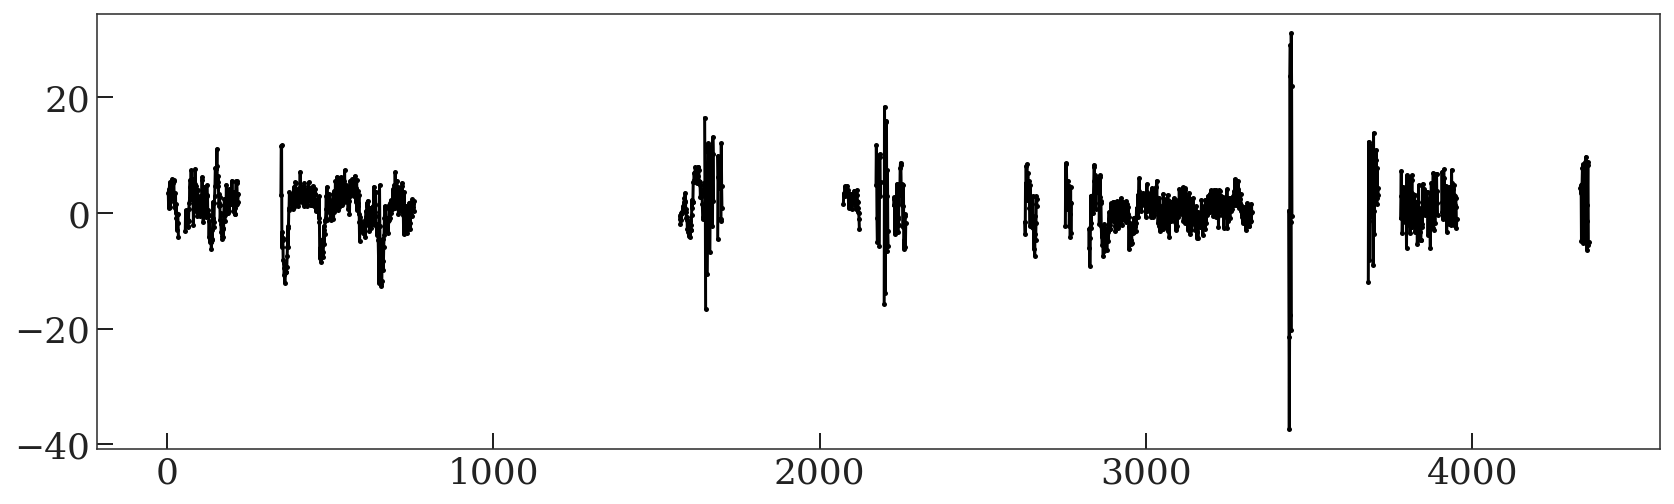

In [101]:
bag_of_hacks_cross_correlate(
    masked_s, normed_ref_spectrum, 
    K_half=7, dv=dv, v0=visit['VREL']*u.km/u.s)

---

In [80]:
# spectra = visit.get_frame_spectra()
# masked_template_spectrum = apply_masks(combined_spectrum)
# masked_s = apply_masks(spectra[24900035])
# shifted_flux = shift_and_interpolate_splits(
#     masked_template_spectrum, 0*u.km/u.s, masked_s.wavelength)

In [81]:
# plt.figure(figsize=(15, 4))
# # plt.plot(masked_template_spectrum.wavelength, masked_template_spectrum.flux, 
# #          marker='', alpha=0.5)
# plt.plot(masked_s.wavelength, shifted_flux, marker='')

24900035


TypeError: cannot unpack non-iterable NoneType object

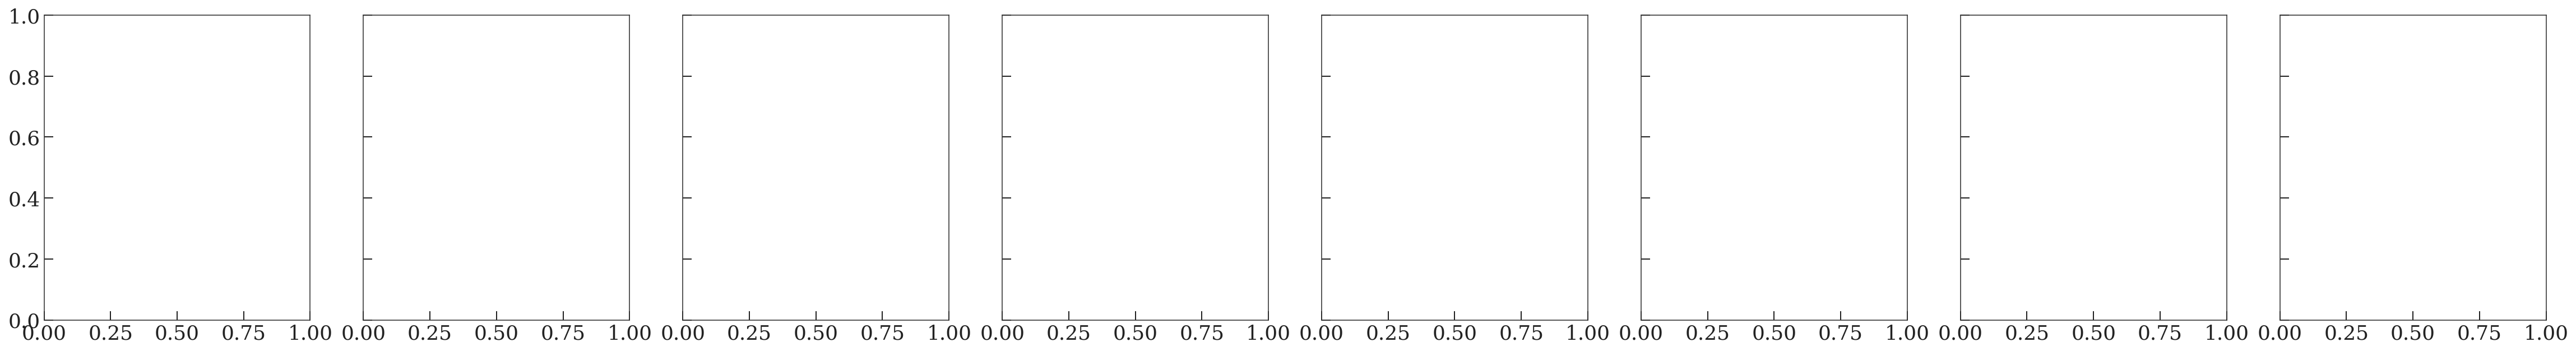

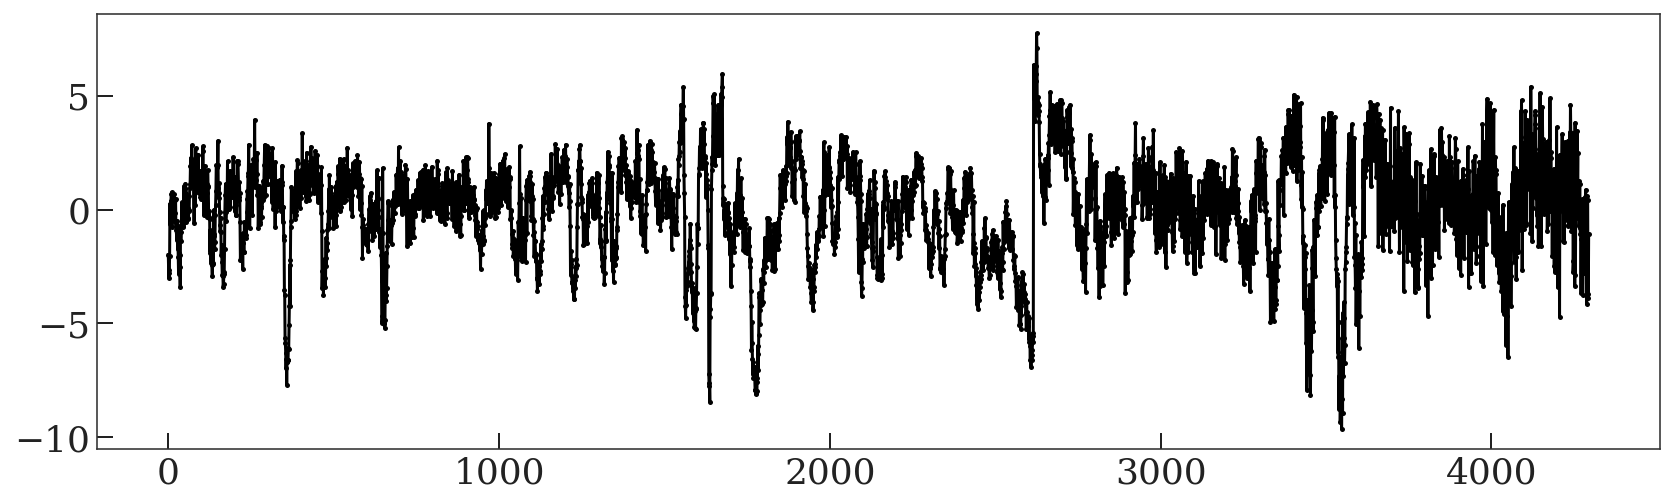

In [83]:
# for cross-correlation
dv = 4 * u.km/u.s

mjds = []
cc_rvs = []
visit_vrels = []
rv_corrections = []
visit_pmf = []

np.random.seed(42)

# for visit in sorted(visits, key=lambda x: x['JD']):
for visit in visits:
    spectra = visit.get_frame_spectra()
    
    other_visits = [v for v in visits if v['FILE'] != visit['FILE']]
    
    cc_fig, cc_axes = plt.subplots(1, len(spectra), 
                                   figsize=(5 * len(spectra), 5),
                                   sharex=True, sharey=True)
    
    for j, (frame, s) in enumerate(spectra.items()):
        print(frame)
        
        time = visit.frame_times[frame]
        
        template_spectrum = apply_masks(combined_spectrum, fillnan=True)
        s = apply_masks(s, fillnan=True)
        masked_template_spectrum = apply_masks(combined_spectrum)
        masked_s = apply_masks(s)
        
        normed_ref_spectrum = normalize_ref_to_frame(
            masked_s, masked_template_spectrum, deg=9,  # MAGIC NUMBER
            dv=visit['VREL']*u.km/u.s)
        
        fig, filename = plot_normalized_ref_spectrum(
            visit, frame,
            s, template_spectrum, normed_ref_spectrum)
        filename.parent.mkdir(exist_ok=True, parents=True)
        fig.savefig(filename, dpi=250)
        plt.close(fig)
        
        cc, cc_vs, (ffd, M) = bag_of_hacks_cross_correlate(
#         cc, vs = cross_correlate(
            s, normed_ref_spectrum, 
            K_half=7, dv=dv, v0=visit['VREL']*u.km/u.s)
        cc_dv, cc_poly = parabola_optimum(cc_vs.value, cc)
        
        cc_rvs.append(cc_dv)
        visit_vrels.append(visit['VREL'])
        mjds.append(time.tcb.mjd)
        
        rv_correct = visit.skycoord.radial_velocity_correction(
            obstime=time, location=visit.earth_location).to_value(u.km/u.s)
        rv_corrections.append(rv_correct)
        
        visit_pmf.append((int(visit['PLATE']), 
                          int(visit['FIBERID']), 
                          int(visit['FIBERID'])))

        # ---
            
        ax = cc_axes[j]
        grid = np.linspace(visit['VREL'] - 2*dv.value, 
                           visit['VREL'] + 2*dv.value, 
                           128)
        if cc_poly is not None:
            ax.plot(grid, cc_poly(grid), marker='', 
                    zorder=-10, color='tab:blue', alpha=0.5)
        ax.scatter(cc_vs.value, cc, color='#aaaaaa')
        ax.axvline(cc_dv, color='tab:green')
        
        break
    
    break
    
    cc_fig.tight_layout()
    cc_fig.savefig(plot_path / visit['APOGEE_ID'] / f"{visit['FILE']}-cc.png", dpi=250)
    plt.close(cc_fig)
        
mjds = np.array(mjds)
cc_rvs = np.array(cc_rvs)
visit_vrels = np.array(visit_vrels)
rv_corrections = np.array(rv_corrections)
visit_pmf = np.array(visit_pmf)

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(ffd)
plt.plot(M[:, 10])

In [12]:
np.isfinite(cc_rvs).sum(), np.isnan(cc_rvs).sum(), len(cc_rvs)

(26, 1, 27)

In [13]:
plt.plot(mjds[mjds.argsort()], cc_rvs[mjds.argsort()], marker='.', ls='-')

AttributeError: 'list' object has no attribute 'argsort'

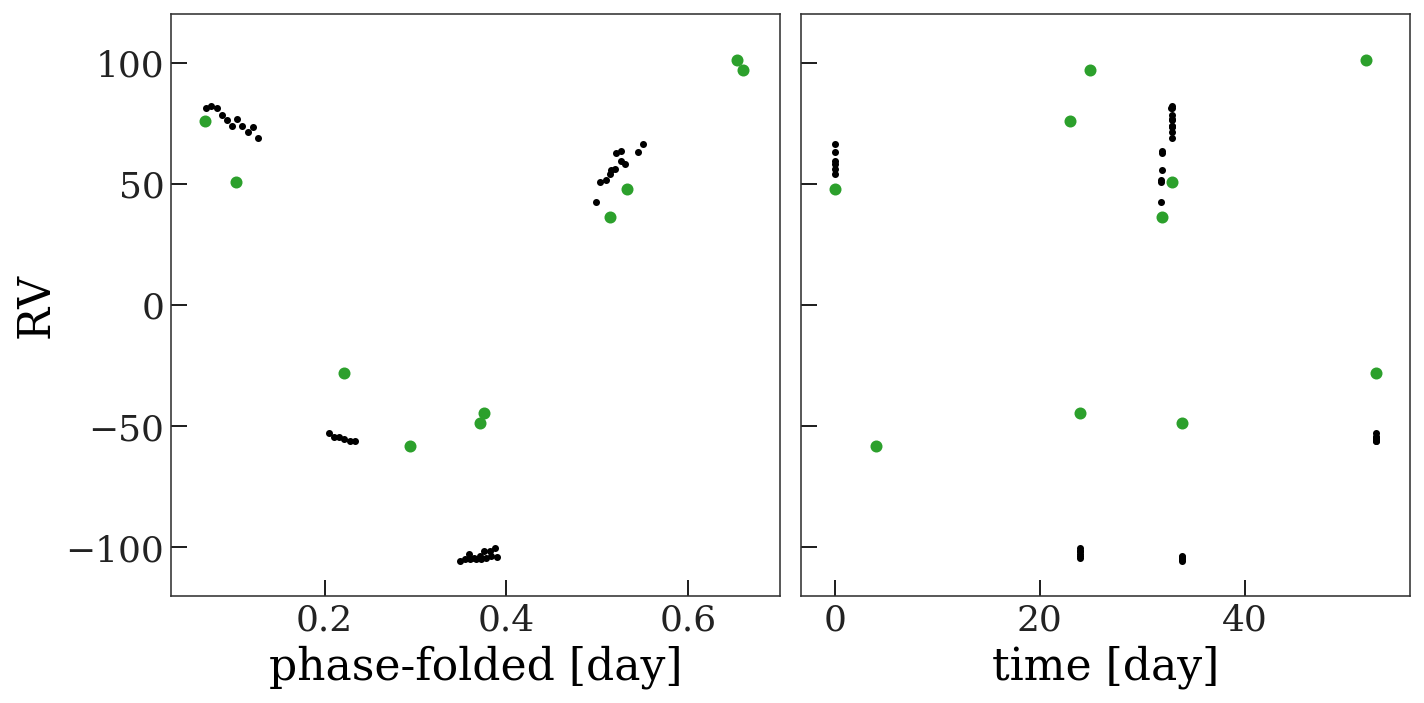

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

ax = axes[0]
ax.scatter(mjds % P, rv_corrections + cc_rvs + visit_vrels, marker='.')
# plt.scatter((mjds / P) % 1, rv_corrections + kernel_rvs + visit_vrels, marker='.')
ax.set_ylim(-120, 120)

ax.scatter(Time([v['JD'] for v in visits], format='jd').mjd % P, 
           [v['VHELIO'] for v in visits], 
           color='tab:green')

ax.set_xlabel('phase-folded [day]')
ax.set_ylabel('RV')

ax = axes[1]
ax.scatter(mjds - mjds.min(), rv_corrections + cc_rvs + visit_vrels, marker='.')
ax.scatter(Time([v['JD'] for v in visits], format='jd').mjd - mjds.min(), 
           [v['VHELIO'] for v in visits], 
           color='tab:green')
ax.set_xlabel('time [day]')

fig.set_facecolor('w')
fig.tight_layout()

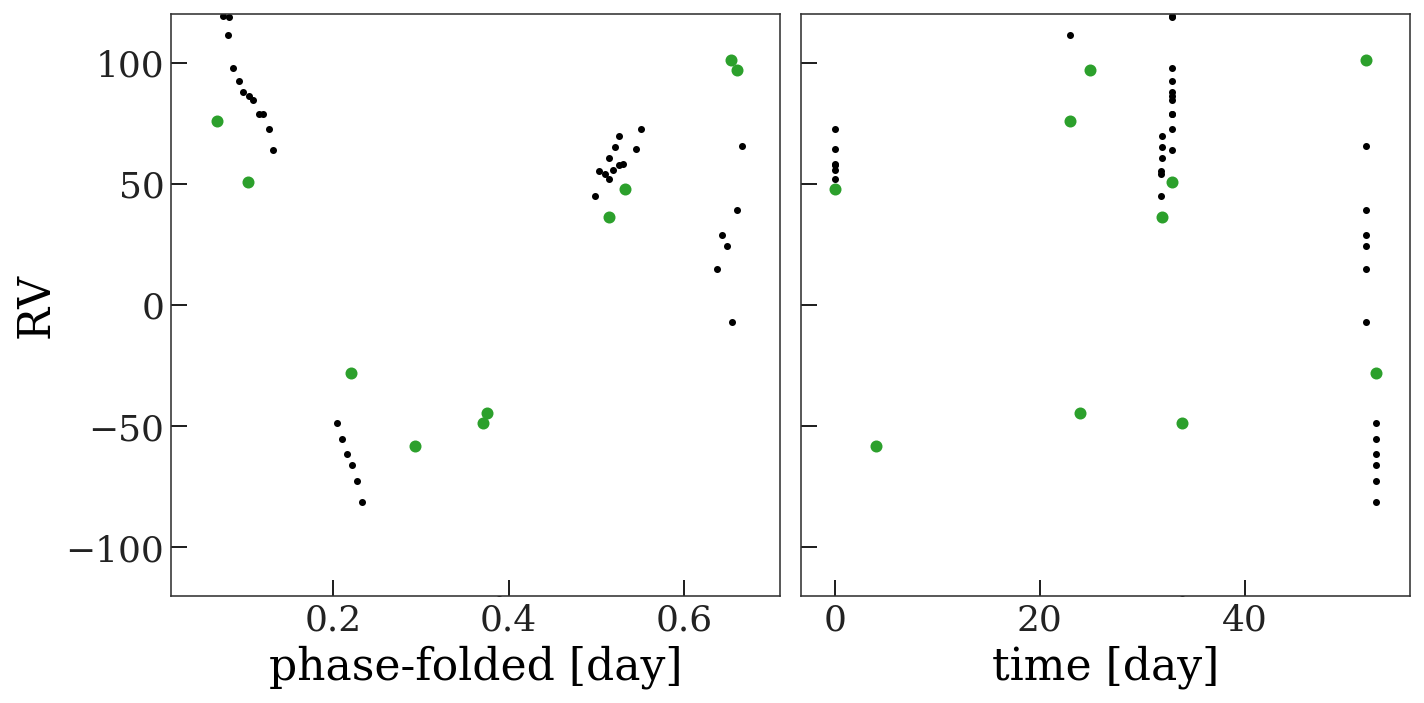

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

ax = axes[0]
ax.scatter(mjds % P, rv_corrections + cc_rvs + visit_vrels, marker='.')
# plt.scatter((mjds / P) % 1, rv_corrections + kernel_rvs + visit_vrels, marker='.')
ax.set_ylim(-120, 120)

ax.scatter(Time([v['JD'] for v in visits], format='jd').mjd % P, 
           [v['VHELIO'] for v in visits], 
           color='tab:green')

ax.set_xlabel('phase-folded [day]')
ax.set_ylabel('RV')

ax = axes[1]
ax.scatter(mjds - mjds.min(), rv_corrections + cc_rvs + visit_vrels, marker='.')
ax.scatter(Time([v['JD'] for v in visits], format='jd').mjd - mjds.min(), 
           [v['VHELIO'] for v in visits], 
           color='tab:green')
ax.set_xlabel('time [day]')

fig.set_facecolor('w')
fig.tight_layout()

Figure: APOGEE visit data with Joker samples

Figure: APOGEE visit data greyed out background, with Joker samples run on this data

TODO: formal error bars

TODO: find high SNR, high NVISITS stars in logg range: 3.2–3.8 (see Sam's chat)

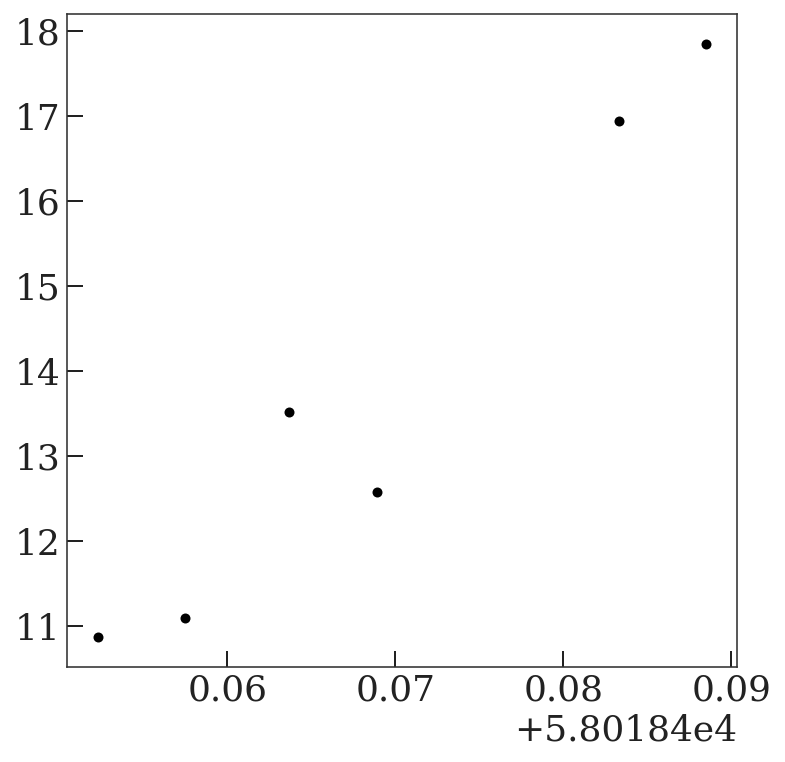

In [79]:
nights = mjds.astype(int)
for n in np.unique(nights):
    plt.figure()
    plt.plot(mjds[nights == n], (rv_corrections + cc_rvs)[nights == n],
             marker='o', ls='none')

(370, 375)

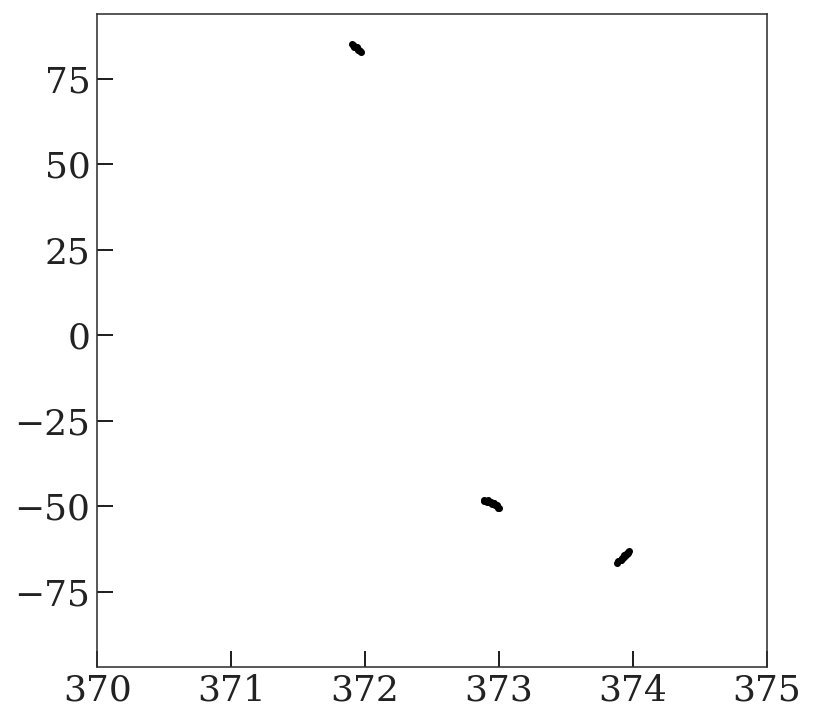

In [116]:
# plt.scatter(mjds, rv_corrections + cc_rvs + visit_vrels, marker='.')
plt.scatter(mjds - mjds.min(), rv_corrections - cc_rvs + visit_vrels, marker='.')
plt.xlim(370, 375)

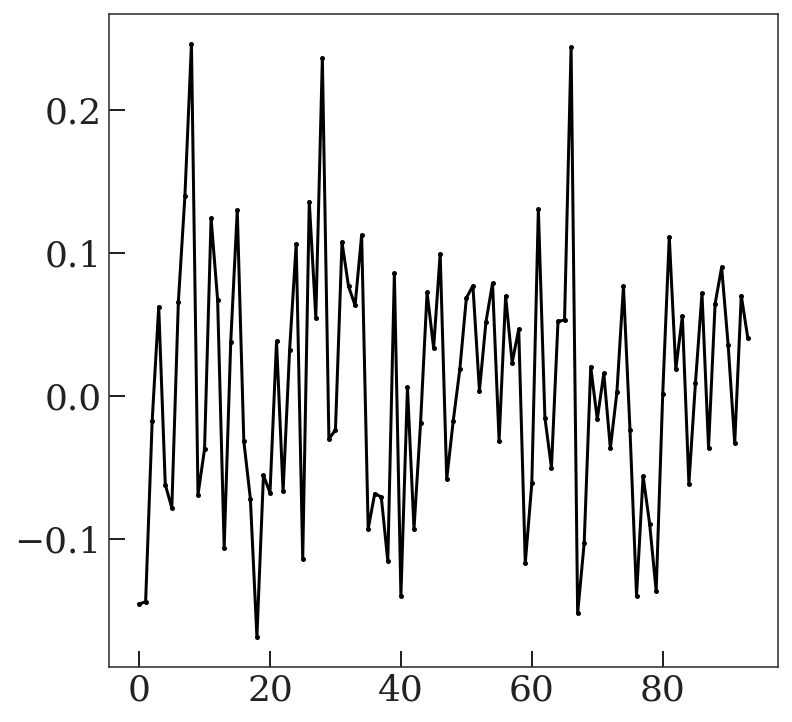

In [103]:
# plt.scatter(mjds, rv_corrections + cc_rvs + visit_vrels, marker='.')
# plt.scatter(mjds, rv_corrections - cc_rvs + visit_vrels, marker='.')

# plt.scatter((mjds / 2.8753170) % 1, rv_corrections - cc_rvs + visit_vrels, marker='.')
# plt.scatter(mjds, cc_rvs, marker='.')
plt.plot(cc_rvs[mjds.argsort()], marker='.', ls='-')

# plt.scatter(mjds, rv_corrections)

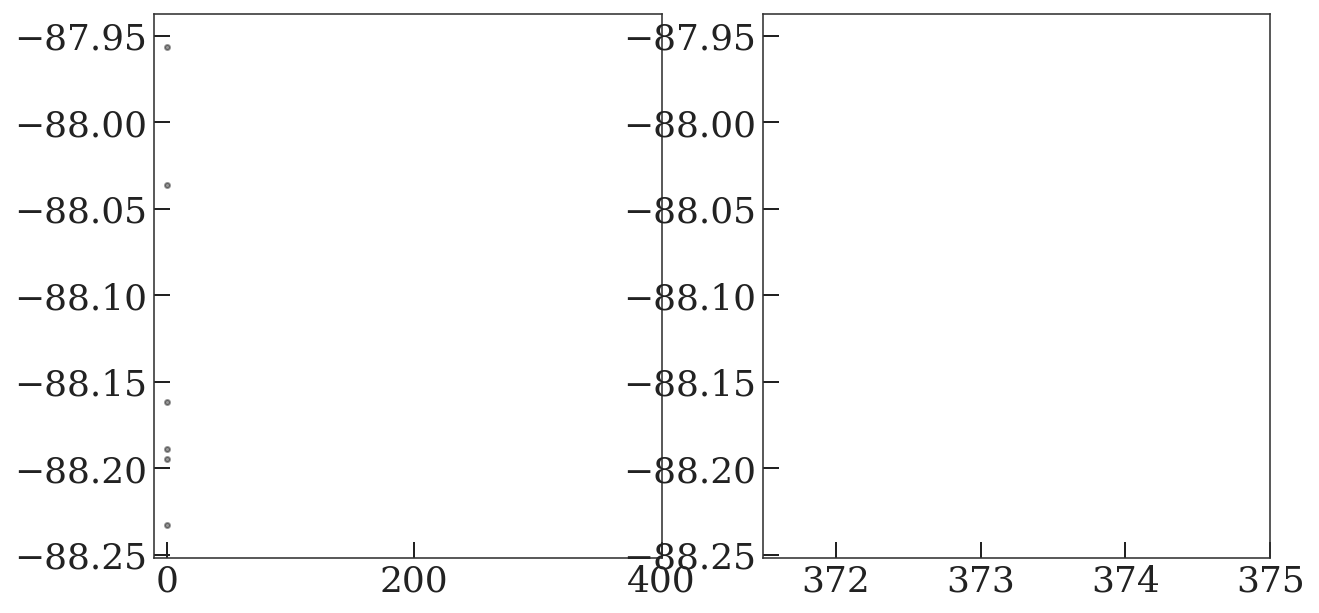

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(mjds - min(mjds), visit_rvs - cc_rvs, 
           marker='.', alpha=0.4)
# ax.set_ylim(-20, 70)
ax.set_xlim(-10, 400)

ax = axes[1]
ax.scatter(mjds - min(mjds), visit_rvs - cc_rvs, 
           marker='.', alpha=0.4)
# ax.set_xlim(-0.2, 1.2)
ax.set_xlim(371.5, 375)
    
fig.set_facecolor('w')

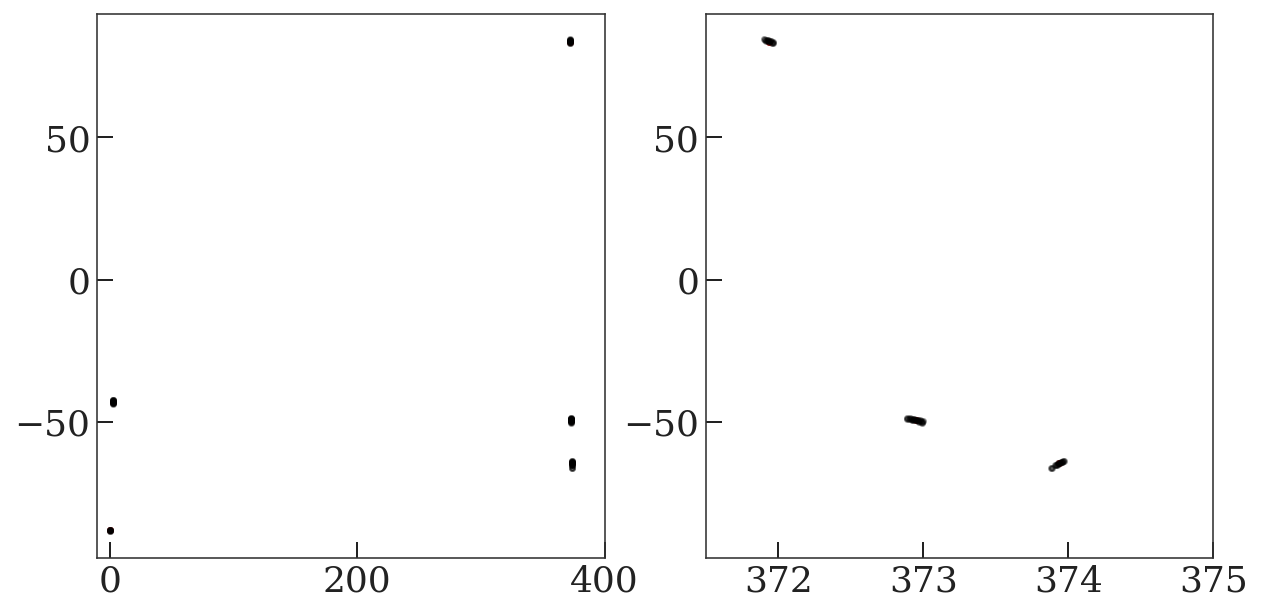

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(mjds - min(mjds), visit_rvs - cc_rvs, 
           marker='.', alpha=0.4)
# ax.set_ylim(-20, 70)
ax.set_xlim(-10, 400)

ax = axes[1]
ax.scatter(mjds - min(mjds), visit_rvs - cc_rvs, 
           marker='.', alpha=0.4)
# ax.set_xlim(-0.2, 1.2)
ax.set_xlim(371.5, 375)

for ax in axes:
    ax.scatter(Time(visits_tbl['JD'], format='jd').mjd - min(mjds),
               visits_tbl['VHELIO'],
               marker='.', color='tab:red', zorder=-100)
    
fig.set_facecolor('w')

(-20, 70)

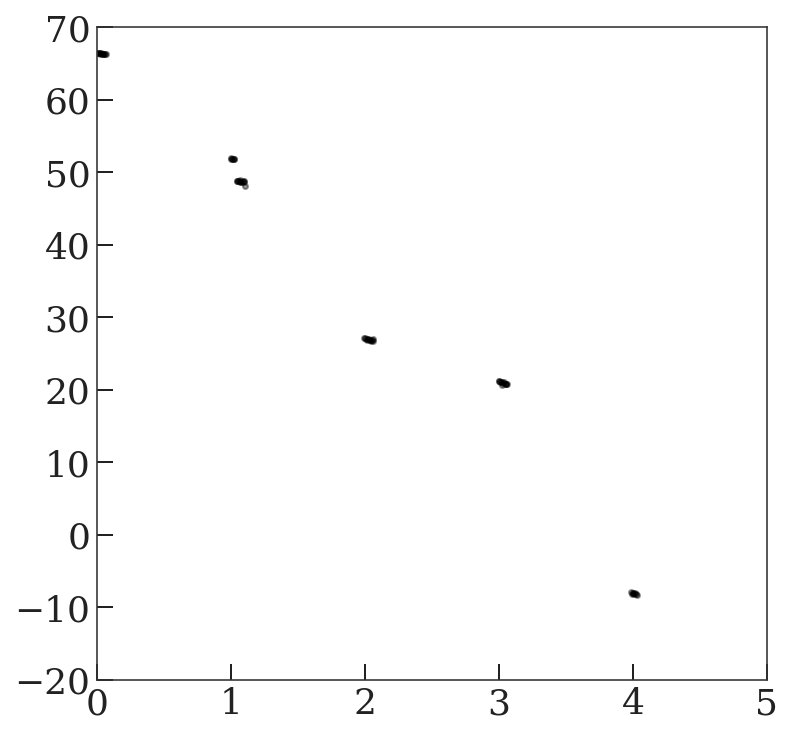

In [50]:
plt.scatter(mjds - min(mjds), kernel_rvs + visit_rvs, marker='.', alpha=0.4)
plt.xlim(0, 5)
plt.ylim(-20, 70)

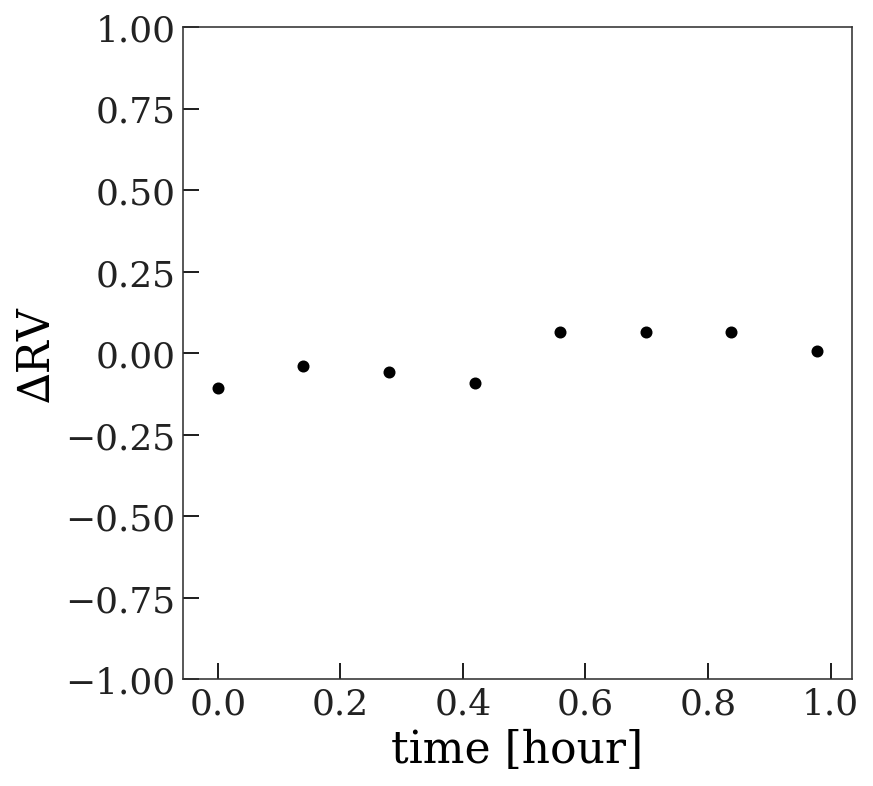

In [79]:
# plt.scatter(np.array(mjds) - min(mjds), visit['VHELIO'] - np.array(dvs))
# plt.scatter(np.array(mjds) - min(mjds), visit['VHELIO'] - np.array(cc_dvs))
# plt.plot(np.array(mjds) - min(mjds), orbit.radial_velocity(Time(mjds, format='mjd')))

fig = plt.figure()
# plt.scatter((np.array(mjds) - min(mjds)) * 24, np.array(dvs))
plt.scatter((np.array(mjds) - min(mjds)) * 24, np.array(cc_dvs))
plt.xlabel('time [hour]')
plt.ylabel('∆RV')
# plt.ylim(-5, 5)
plt.ylim(-1, 1)
fig.set_facecolor('w')

### TODO

- Multiple visits
- Plot visit velocities and frame velocities
- Compare stitching CC's and centroided velocities
- Improve the CC code to best practices (subtract the mean?)

In [24]:
from scipy.ndimage import gaussian_filter1d
from astropy.stats import sigma_clip

In [117]:
smooth = 100  # MAGIC

In [184]:
visit = visits[0]
spectra = visit.load_frame_spectra()

for frame, s in spectra.items():
    print(frame)

    time = visit.frame_times[frame]

    normed_ref_spectrum = normalize_ref_to_frame(
        s, visit.spectrum, deg=7)
    
    break

22950020


In [219]:
# f = normed_ref_spectrum.flux.copy()
# clipped_local = sigma_clip(f - 0.5*np.roll(f, 1) - 0.5*np.roll(f, -1), 
#                            sigma=5, maxiters=10)

# fuck = f - 0.5*np.roll(f, 1) - 0.5*np.roll(f, -1)

# plt.figure()
# plt.plot(normed_ref_spectrum.wavelength, fuck)
# plt.plot(normed_ref_spectrum.wavelength[clipped_local.mask], 
#          fuck[clipped_local.mask], color='r', ls='none', marker='.')

# plt.figure()
# plt.plot(normed_ref_spectrum.wavelength, normed_ref_spectrum.flux)
# plt.plot(normed_ref_spectrum.wavelength[clipped_local.mask], 
#          normed_ref_spectrum.flux[clipped_local.mask], 
#          color='r', ls='none', marker='.')

# normed_ref_spectrum = Spectrum1D(
#     f[~clipped_local.mask],
#     spectral_axis=normed_ref_spectrum.wavelength[~clipped_local.mask]
# )

In [186]:
# smooth_frame_flux = gaussian_filter1d(s.flux, sigma=smooth)
# frame_flux_diff = s.flux - smooth_frame_flux
# frame_flux_diff /= np.linalg.norm(frame_flux_diff)
# # plt.plot(frame_flux_diff)

In [187]:
# from subframe.velocity import shift_and_interpolate
# frame_spectrum = s

# shifted_flux = shift_and_interpolate(normed_ref_spectrum,
#                                      0,
#                                      frame_spectrum.wavelength)

# smooth_ref_flux = gaussian_filter1d(shifted_flux, sigma=smooth)
# ref_flux_diff = shifted_flux - smooth_ref_flux
# ref_flux_diff /= np.linalg.norm(ref_flux_diff)

# clipped = sigma_clip(frame_flux_diff - ref_flux_diff, sigma=3)
# clip_mask = clipped.mask.copy()
# for shift in np.arange(-1, 1+1):
#     clip_mask |= np.roll(clip_mask, shift=shift)
# clip_mask[0] = clip_mask[-1] = 1

# print(clip_mask.sum())
# clipped_local = sigma_clip(frame_flux_diff - 0.5*np.roll(frame_flux_diff, 1) - 0.5*np.roll(frame_flux_diff, -1), 
#                            sigma=5)
# clip_mask |= clipped_local.mask
# print(clip_mask.sum())

488
489


In [188]:
# tmp = Spectrum1D(
#     shifted_flux[~clipped.mask] * u.one,
#     spectral_axis=frame_spectrum.wavelength[~clipped.mask])

In [189]:
dv = 8*u.km/u.s
vs = np.arange(-1, 1+1) * dv
terms = []
for v in vs:
    shifted_flux = shift_and_interpolate(normed_ref_spectrum,
                                         v,
                                         frame_spectrum.wavelength[~clip_mask])
    
    smooth_ref_flux = gaussian_filter1d(shifted_flux, sigma=smooth)
    ref_flux_diff = shifted_flux - smooth_ref_flux
    ref_flux_diff /= np.linalg.norm(ref_flux_diff)
    
    terms.append(ref_flux_diff)

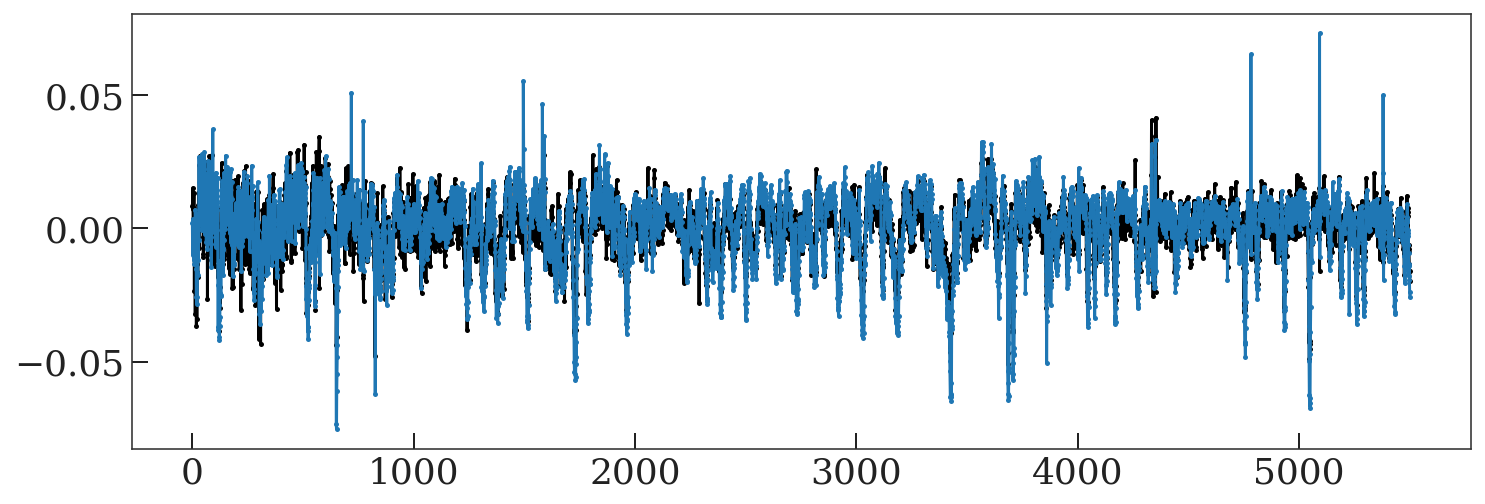

In [190]:
plt.figure(figsize=(12, 4))
plt.plot(frame_flux_diff[~clip_mask])
plt.plot(terms[0])

In [191]:
# M = np.stack(terms).T
# from subframe.utils import parabola_optimum

In [220]:
# Cinv = 1 / frame_spectrum.uncertainty.array**2

# # denom = np.sqrt(np.diag((M.T * Cinv) @ M) *
# #                 ((frame_spectrum.flux.T * Cinv) @ frame_spectrum.flux))
# # crosscorr = ((M.T * Cinv) @ frame_spectrum.flux) / denom

# cc = M.T @ frame_flux_diff[~clip_mask]

# cc_dv, _ = parabola_optimum(vs.value, cc)
# cc_dv

In [221]:
# cc, vs = cross_correlate(
#     s, normed_ref_spectrum, 
#     K_half=1)
# cc_dv_old, _ = parabola_optimum(vs.value, cc)
# cc_dv_old